# Portfolio risk estimation

In [163]:
from pandas_datareader.data import DataReader
from pandas_datareader.moex import MoexReader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from finance import plot_adjusted_price, plot_instruments_correlation, plot_mean_avg, correlation_matrix, getData
import datetime
from dateutil.relativedelta import relativedelta
from cvxopt import matrix, solvers
sns.set_style("whitegrid")
%matplotlib inline

In [164]:
symbols= """
GNL
SBRA
APLE
""".strip().split()

In [165]:
start_date = "2016-01-01"
end_date = "2020-11-01"
tickers_data =  getData(symbols, start_date=start_date, end_date=end_date)

GNL First not NA value date: 2016-01-04 00:00:00
SBRA First not NA value date: 2016-01-04 00:00:00
APLE First not NA value date: 2016-01-04 00:00:00


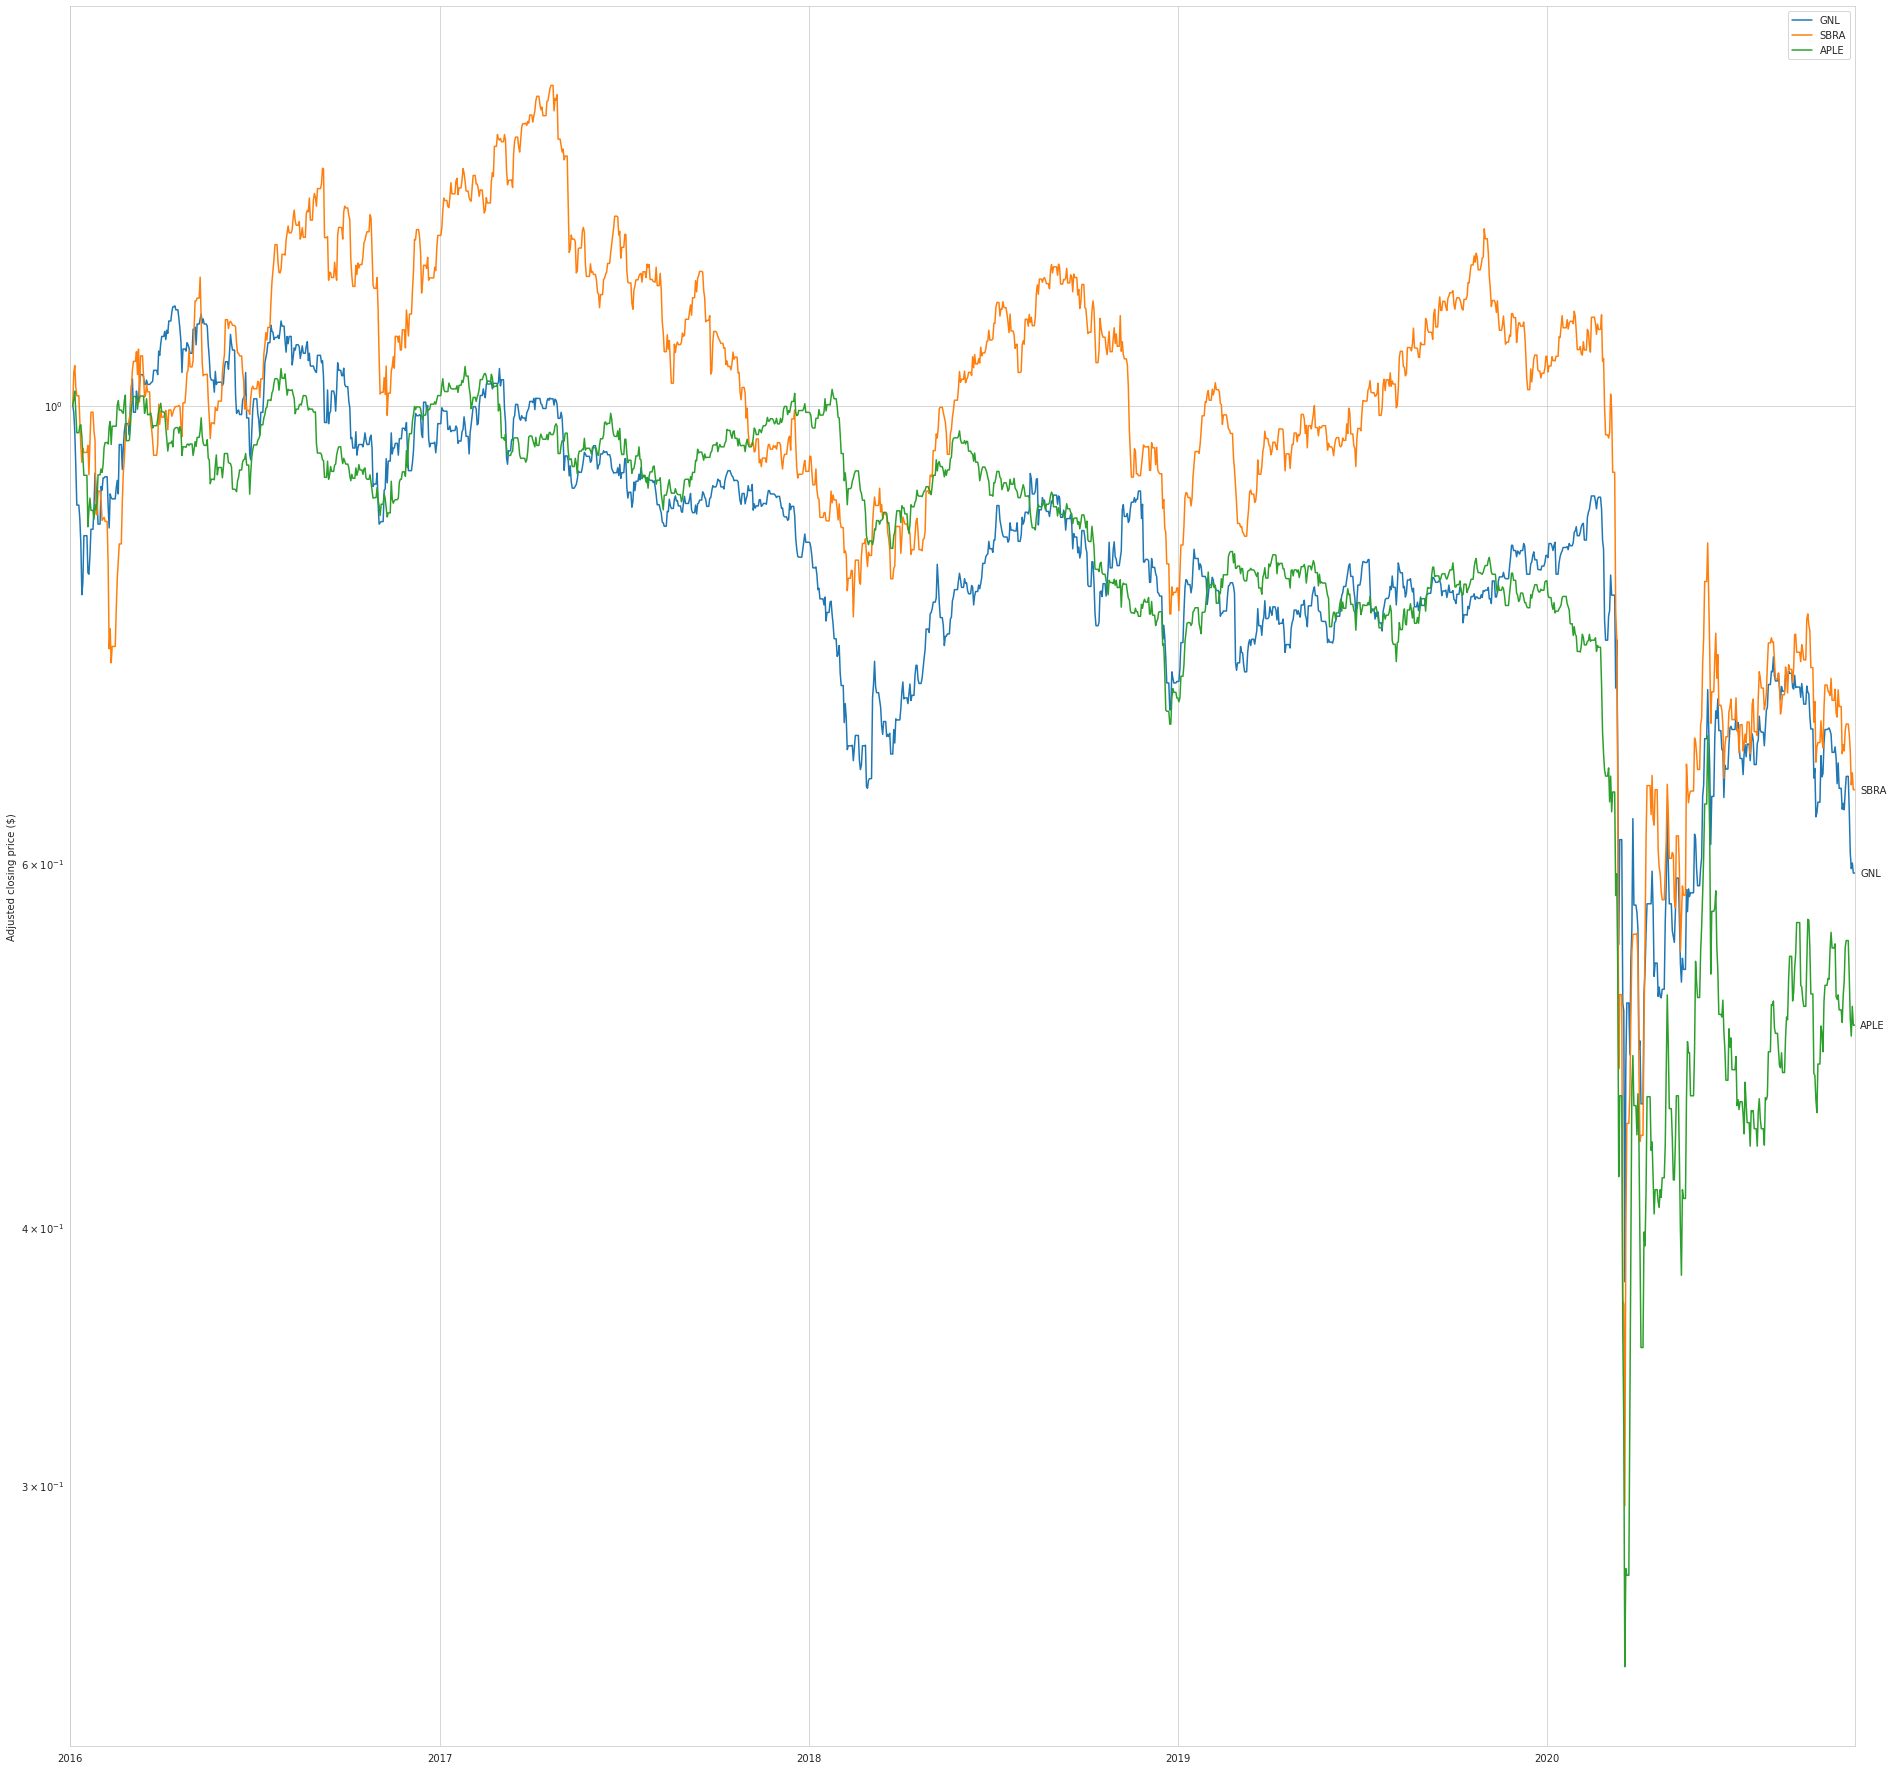

In [166]:
ax = plot_adjusted_price(tickers_data, (32,32))
ax.set_yscale("log")
#plot_adjusted_price(tickers_data.loc[:, (tickers_data / tickers_data.iloc[0, :]).iloc[-1] < 1], figsize=(16,20))

In [134]:
def get_accet_returns(tickers_data, delta=relativedelta(months=1)):
    cur_date = tickers_data.index.min() + delta
    max_date = tickers_data.index.max()

    accet_return = pd.DataFrame(columns=tickers_data.columns)
    while cur_date < max_date:
        prev_date = cur_date - delta
        accet_return.loc[cur_date] = (tickers_data.loc[cur_date] - tickers_data.loc[prev_date]) / tickers_data.loc[prev_date]
        cur_date += delta
       
    return accet_return.replace([np.inf, -np.inf], np.nan)

accet_return = get_accet_returns(tickers_data)

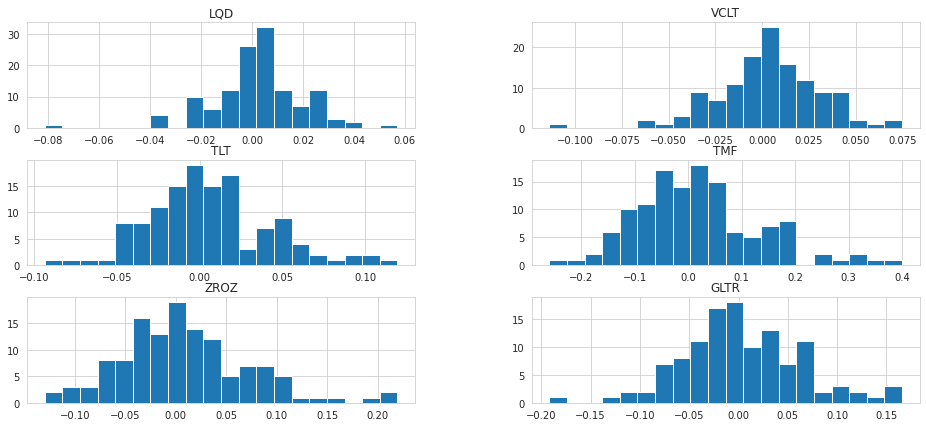

In [135]:
_ = accet_return.hist(bins=20, figsize=(16,7))

In [136]:
avarage_return = accet_return.mean(axis=0)
std_return = accet_return.std(axis=0)
corr_return = accet_return.corr()

In [137]:
print(avarage_return)
print(std_return)
print(corr_return)

LQD     0.002152
VCLT    0.003218
TLT     0.005290
TMF     0.018911
ZROZ    0.009036
GLTR    0.003466
dtype: float64
LQD     0.018097
VCLT    0.028090
TLT     0.038439
TMF     0.116080
ZROZ    0.063807
GLTR    0.061025
dtype: float64
           LQD      VCLT       TLT       TMF      ZROZ      GLTR
LQD   1.000000  0.961885  0.457850  0.469443  0.445211  0.325562
VCLT  0.961885  1.000000  0.576499  0.589575  0.574812  0.259867
TLT   0.457850  0.576499  1.000000  0.995856  0.988956  0.068793
TMF   0.469443  0.589575  0.995856  1.000000  0.988860  0.060816
ZROZ  0.445211  0.574812  0.988956  0.988860  1.000000  0.052360
GLTR  0.325562  0.259867  0.068793  0.060816  0.052360  1.000000


In [138]:
def portfolio_avarage_return(weights, avarage_return):
    return (weights * avarage_return).sum()

def portfolio_std_return(weights, std_return, corr_return):
    std_return = std_return.values[:, np.newaxis]
    weights = weights.values[:, np.newaxis]
    return (weights.dot(weights.T) * std_return.dot(std_return.T) * corr_return).sum().sum()

In [139]:
P = 2 * matrix(std_return.values * std_return.values[:, np.newaxis] * corr_return.values)
q = matrix(np.zeros_like(std_return.values))
n = len(std_return)
# G = matrix(np.zeros(shape=(n,1)), (1, len(std_return)))
# h = matrix([[0.0]])
G = -matrix(1.0 * np.diag([1]*len(corr_return)))
h = matrix(q)
A = matrix([
        [1.0] * len(std_return),
    ], 
    (len(std_return),1)
).trans()
b = matrix([1.0])

sol=solvers.qp(P, q, G, h, A, b, verbose=False)
best_weights = pd.Series(sol["x"], index=std_return.index)
best_weights[best_weights<1e-6] = 0
best_weights /= best_weights.sum()
print("\nPortfolio with lowest risk:")
print(best_weights)

     pcost       dcost       gap    pres   dres
 0:  1.8174e-03 -1.0008e+00  1e+00  2e-16  3e+00
 1:  1.8017e-03 -1.0813e-02  1e-02  1e-16  4e-02
 2:  1.2429e-03 -4.4195e-04  2e-03  2e-16  4e-03
 3:  4.7103e-04 -2.2844e-04  7e-04  8e-16  1e-18
 4:  3.6185e-04  3.0803e-04  5e-05  2e-16  2e-18
 5:  3.3113e-04  3.2604e-04  5e-06  1e-16  9e-19
 6:  3.2765e-04  3.2727e-04  4e-07  1e-16  9e-19
 7:  3.2743e-04  3.2740e-04  2e-08  1e-16  4e-19
Optimal solution found.

Portfolio with lowest risk:
LQD     0.991436
VCLT    0.000000
TLT     0.008503
TMF     0.000000
ZROZ    0.000001
GLTR    0.000060
dtype: float64


# Same task for pinned return rate

In [140]:
rs = np.linspace(avarage_return.min()/1.2, avarage_return.max()*1.1, 100)
ws = {}

for r in rs:
    P = 2 * matrix(std_return.values * std_return.values[:, np.newaxis] * corr_return.values)
    q = matrix(np.zeros_like(std_return.values))
    G = -matrix(1.0 * np.diag([1]*len(corr_return)))
    h = matrix(q)
    n = len(std_return)
    A = matrix([
            [1.0] * len(std_return),
            list(avarage_return.values)
        ], 
        (len(std_return),2)
    ).trans()
    b = matrix([1.0, r])

    sol=solvers.qp(P, q, G, h, A, b, verbose=False)
    if sol["status"] == "unknown":
        continue
    weights = pd.Series(sol["x"], index=std_return.index)
    weights[weights<1e-6] = 0
    weights /= weights.sum()
    ws[r] = weights
ws = pd.DataFrame(ws).T
print(ws)

     pcost       dcost       gap    pres   dres
 0:  5.0146e-04 -9.9051e-01  9e+00  3e+00  3e+00
 1:  5.3864e-04 -6.1059e-01  1e+00  3e-01  3e-01
 2:  5.3235e-04  3.3208e-02  5e-01  1e-01  1e-01
 3:  3.0898e-04  1.6442e-01  1e-01  4e-02  5e-02
 4:  3.0871e-04  8.6381e-01  6e-02  3e-02  4e-02
 5:  3.0869e-04  2.6175e+01  1e-01  3e-02  3e-02
 6:  3.0868e-04  7.9182e+03  3e+00  3e-02  3e-02
 7:  3.0868e-04  2.3200e+07  1e+02  3e-02  3e-02
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres
 0:  5.0675e-04 -9.9569e-01  9e+00  3e+00  3e+00
 1:  5.3830e-04 -6.2481e-01  1e+00  3e-01  3e-01
 2:  5.3379e-04 -3.4071e-02  5e-01  1e-01  1e-01
 3:  3.1702e-04  4.5372e-02  8e-02  2e-02  3e-02
 4:  3.1713e-04  2.1708e-01  3e-02  1e-02  2e-02
 5:  3.1713e-04  7.3709e+00  3e-02  1e-02  2e-02
 6:  3.1713e-04  3.0688e+03  9e-01  1e-02  2e-02
 7:  3.1713e-04  1.0302e+07  4e+01  1e-02  2e-02
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres
 0: 

     pcost       dcost       gap    pres   dres
 0:  5.3285e-03 -1.1658e+00  1e+00  3e-18  4e+00
 1:  5.3275e-03 -8.0543e-03  1e-02  8e-17  4e-02
 2:  5.2512e-03  3.7115e-03  2e-03  2e-16  5e-03
 3:  4.8715e-03  4.4720e-03  4e-04  2e-16  4e-18
 4:  4.8010e-03  4.7162e-03  8e-05  1e-16  3e-18
 5:  4.7623e-03  4.7552e-03  7e-06  2e-16  3e-18
 6:  4.7602e-03  4.7601e-03  7e-08  1e-16  5e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.5123e-03 -1.1678e+00  1e+00  2e-16  4e+00
 1:  5.5113e-03 -7.9591e-03  1e-02  1e-16  4e-02
 2:  5.4328e-03  3.8338e-03  2e-03  1e-16  5e-03
 3:  5.0310e-03  4.5962e-03  4e-04  6e-17  5e-18
 4:  4.9654e-03  4.8762e-03  9e-05  1e-16  4e-18
 5:  4.9263e-03  4.9166e-03  1e-05  2e-16  2e-18
 6:  4.9236e-03  4.9235e-03  1e-07  3e-16  1e-18
 7:  4.9235e-03  4.9235e-03  1e-09  1e-16  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6995e-03 -1.1693e+00  1e+00  3e-18  4e+00
 1:  5.6985e-03 -7.8581e

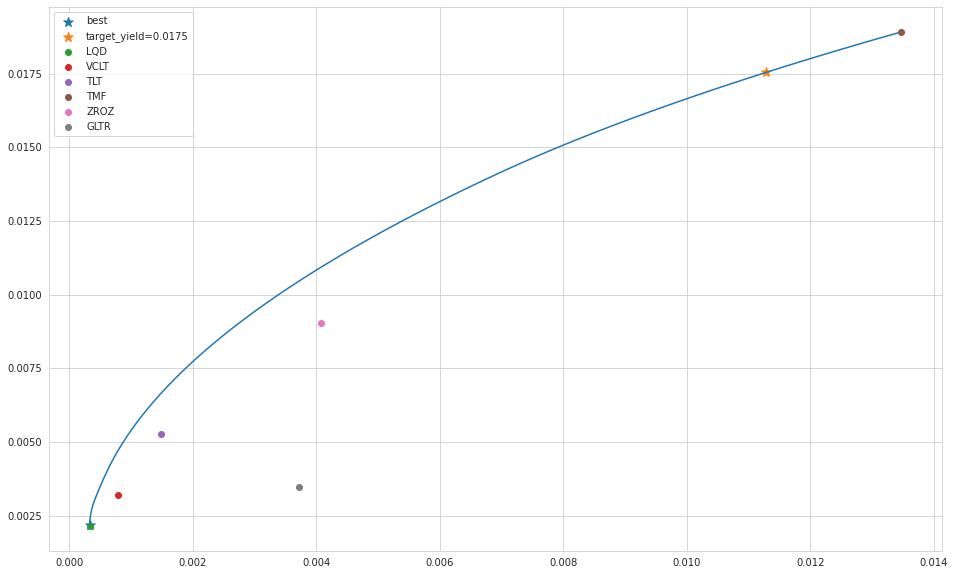

In [141]:
line_x = []
line_y = [] 
for _, weights in ws.iterrows():
    line_x.append(portfolio_std_return(weights, std_return, corr_return))
    line_y.append(portfolio_avarage_return(weights, avarage_return))
    
line_y = np.array(line_y)
line_x = np.array(line_x)

target_yield = 0.0175
target_yield_index = abs(line_y - target_yield).argmin()
target_yield_weights = ws.iloc[target_yield_index]

fig = plt.figure(figsize=(16,10))
ax = plt.subplot(111)
ax.plot(line_x, line_y)

ax.scatter(
    [portfolio_std_return(best_weights, std_return, corr_return)], 
    [portfolio_avarage_return(best_weights, avarage_return)],
    label="best",
    marker="*",
    s=100,
)

ax.scatter(
    [line_x[target_yield_index]], 
    [line_y[target_yield_index]], 
    label=f"target_yield={target_yield}",
    marker="*",
    s=100,
)

for asset_name in ws.columns:
    weights = pd.Series([0]*len(ws.columns), index=ws.columns)
    weights[asset_name] = 1
    ax.scatter(
        [portfolio_std_return(weights, std_return, corr_return)], 
        [portfolio_avarage_return(weights, avarage_return)],
        label=asset_name,
    )
    

ax.legend()

In [142]:
target_yield_weights

LQD     0.000002
VCLT    0.000002
TLT     0.000000
TMF     0.911097
ZROZ    0.000000
GLTR    0.088899
Name: 0.01753815927614842, dtype: float64

In [143]:
tickers_data["lowest risk"] = (tickers_data * best_weights).sum(axis=1)
tickers_data["target yield"] = (tickers_data * target_yield_weights).sum(axis=1)

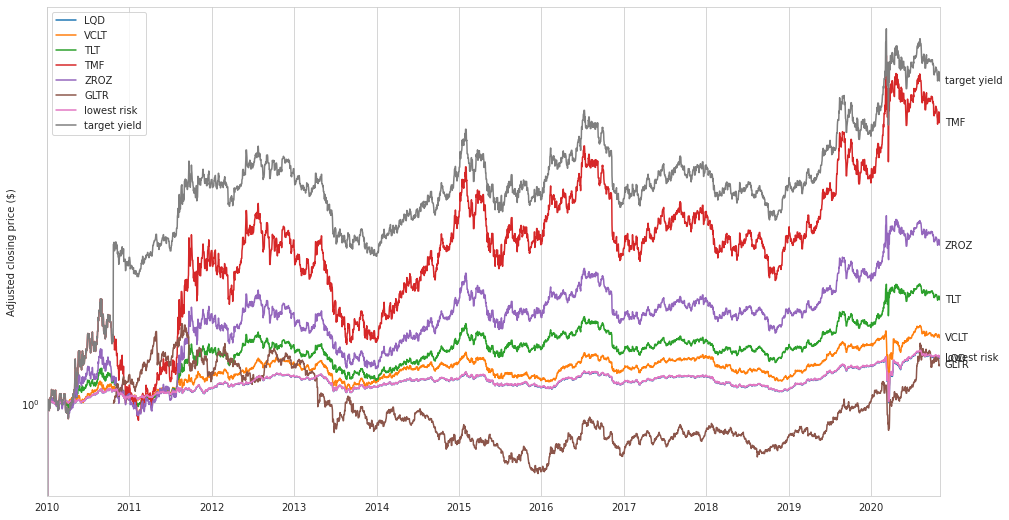

In [144]:
ax = plot_adjusted_price(tickers_data)
ax.set_yscale("log")

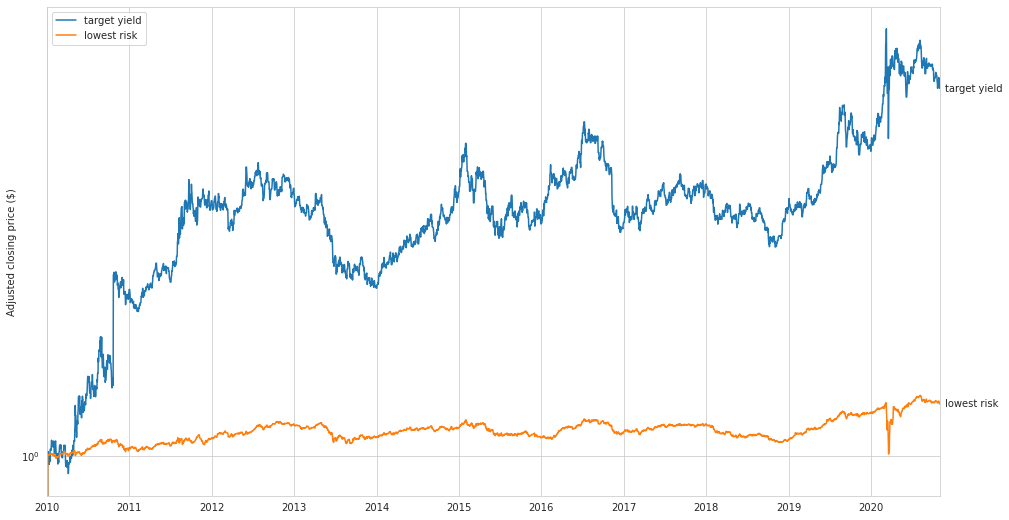

In [145]:
ax = plot_adjusted_price(tickers_data[["target yield", "lowest risk"]])
ax.set_yscale("log")

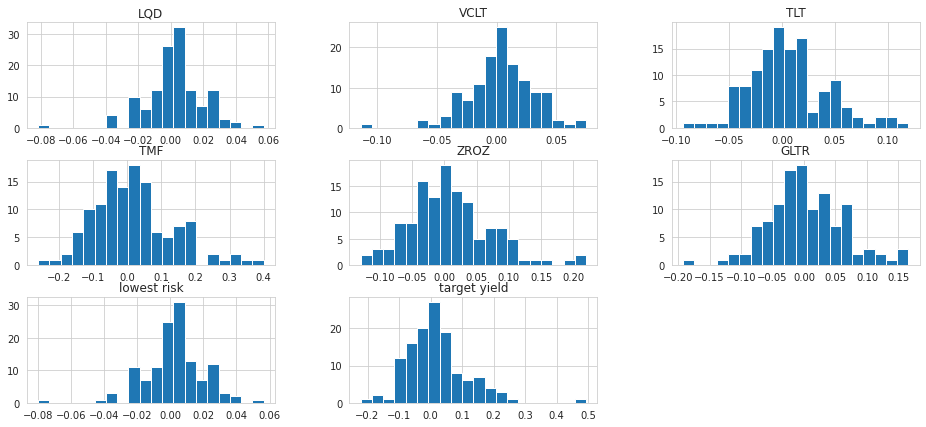

In [146]:
returns = get_accet_returns(tickers_data)
_ = returns.hist(bins=20, figsize=(16,7))